In [2]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset: ", path)

Path to dataset:  /Users/alejandrodiazalvarado/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [4]:
df = pd.read_csv(path+"/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Exploratory Data Analysis (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
#Check null values
print(df[df.isnull().any(axis=1)].count())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
#Check number of churn 
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


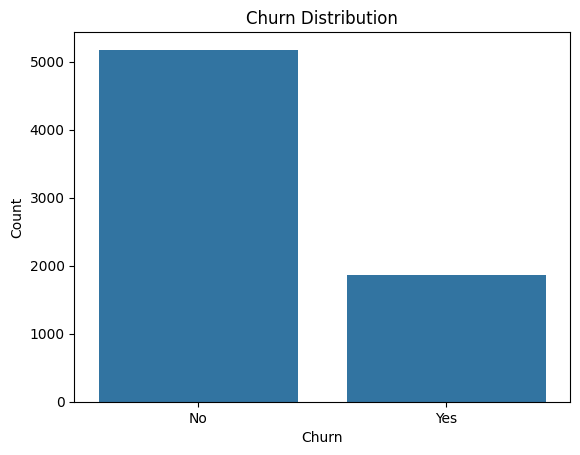

In [8]:
#Churn graph
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [9]:
#Check TotalCharges values
print(df['TotalCharges'].describe())

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object


In [10]:
#Check for non-numeric values in TotalCharges
non_numeric_total_charges = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]
print(non_numeric_total_charges)  # Display rows with non-numeric TotalCharges

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

In [11]:
#Convert TotalCharges to numeric, forcing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.loc[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [12]:
#Now, fill the NaN values in TotalCharges with the mean of the column
mean_total_charges = df['TotalCharges'].mean()
df.fillna({'TotalCharges': mean_total_charges}, inplace=True)


In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
#Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 0


In [15]:
#Check unique values
for col in df.columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in gender: ['Female' 'Male']
Unique values in SeniorCitizen: [0 1]
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Unique values in PhoneService: ['No' 'Yes']
Unique values in MultipleLines: ['No phone service' 'No' 'Yes']
Unique values in InternetService: ['DSL' 'Fiber optic' 'No']
Unique values in OnlineSecurity: ['No' 'Yes' 'No internet service']
Unique values in OnlineBackup: ['Yes' 'No' 'No internet service']
Unique values in DeviceProtection: ['No' 'Yes' 'No internet service']
Unique values in TechSupport: ['No' 'Yes' 'No internet service']
Unique values in StreamingTV: ['No' '

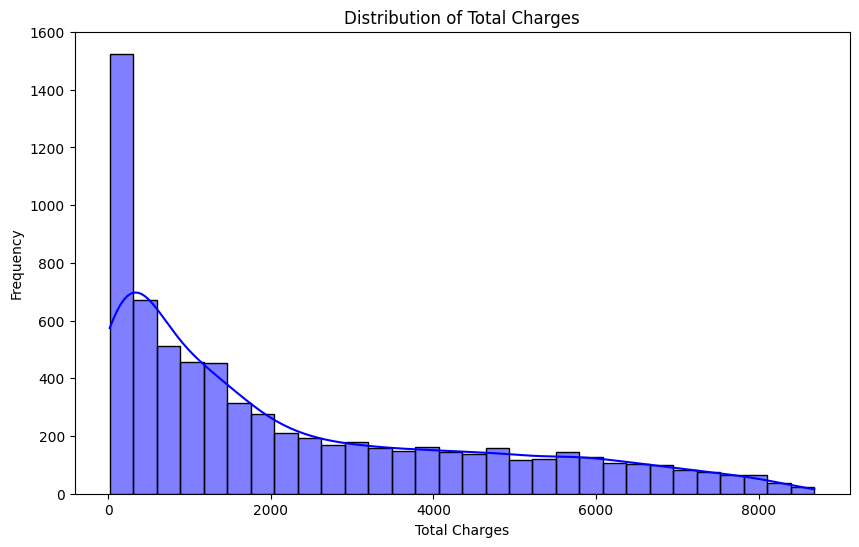

In [16]:
#Distribution of total charges
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalCharges'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

<Axes: ylabel='Count'>

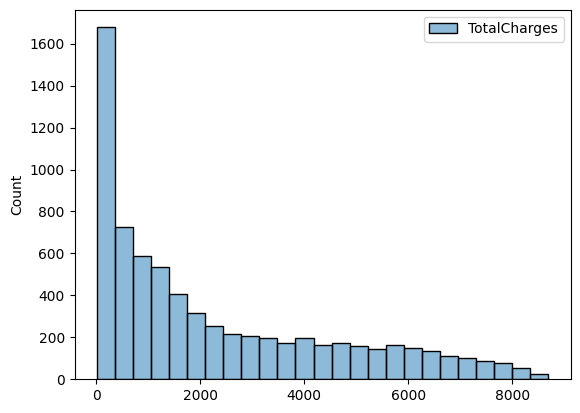

In [43]:
sns.histplot(df[['TotalCharges']])

In [ ]:
Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
out = df[(df['TotalCharges'] < lower_bound)]
print(out)

Q1: 402.225, Q3: 3786.6, IQR: 3384.375
Lower Bound: -4674.3375, Upper Bound: 8863.1625
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]


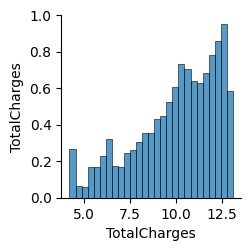

In [37]:
sns.pairplot(np.log2(df[['TotalCharges']]))

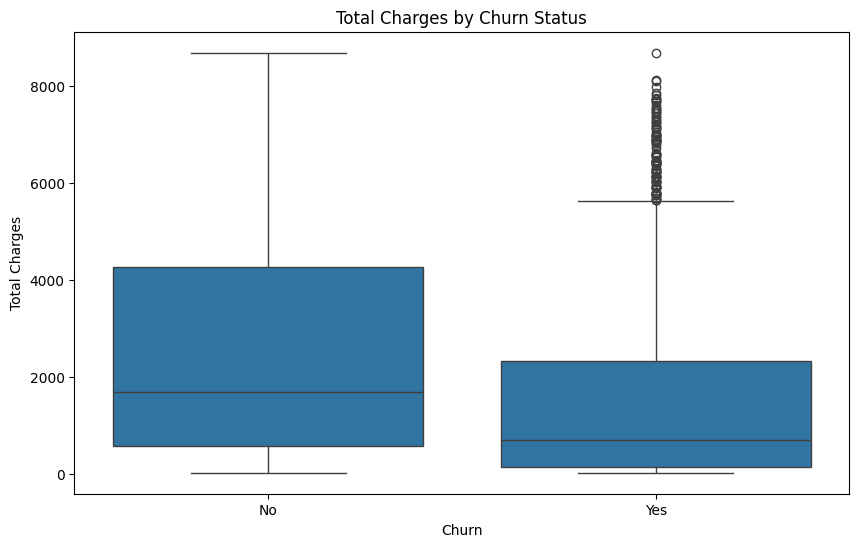

In [17]:
#Distribution of total charges by churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df)   
plt.title('Total Charges by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

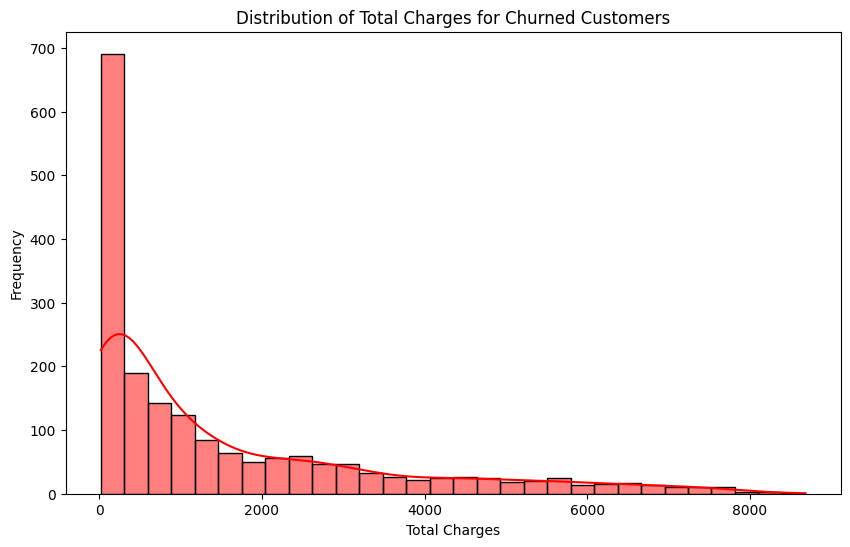

In [18]:
#Distribution of total charges by churn = Yes
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Churn'] == 'Yes']['TotalCharges'], bins=30, kde=True, color='red')
plt.title('Distribution of Total Charges for Churned Customers')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

In [19]:
#Copy the DataFrame
df_copy = df.copy()


In [20]:
#Encode categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in df_copy.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_copy[column] = le.fit_transform(df_copy[column])
    label_encoders[column] = le
#Check the first few rows after encoding
print(df_copy.head())

   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0        5375       0              0        1           0       1   
1        3962       1              0        0           0      34   
2        2564       1              0        0           0       2   
3        5535       1              0        0           0      45   
4        6511       0              0        0           0       2   

   PhoneService  MultipleLines  InternetService  OnlineSecurity  ...  \
0             0              1                0               0  ...   
1             1              0                0               2  ...   
2             1              0                0               2  ...   
3             0              1                0               2  ...   
4             1              0                1               0  ...   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   


In [21]:
#Delete the 'customerID' column
df_copy.drop(columns=['customerID'], inplace=True)


In [22]:
#Transform tenure to log scale
df_copy['tenure'] = df_copy['tenure'].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)

In [23]:
for col in df_copy.columns:
    print(f"Unique values in {col}: {df_copy[col].unique()}")

Unique values in gender: [0 1]
Unique values in SeniorCitizen: [0 1]
Unique values in Partner: [1 0]
Unique values in Dependents: [0 1]
Unique values in tenure: [0.69314718 3.55534806 1.09861229 3.8286414  2.19722458 3.13549422
 2.39789527 3.36729583 4.14313473 2.63905733 2.83321334 4.07753744
 3.91202301 3.25809654 4.24849524 3.97029191 4.27666612 3.09104245
 2.56494936 3.4339872  3.87120101 4.29045944 2.89037176 3.33220451
 1.79175947 3.8501476  2.48490665 4.26267988 4.15888308 3.78418963
 2.77258872 4.11087386 2.94443898 4.20469262 2.30258509 1.38629436
 3.4657359  3.93182563 4.17438727 4.04305127 2.07944154 3.76120012
 3.58351894 3.8918203  3.40119738 4.18965474 3.66356165 4.2341065
 3.49650756 4.02535169 3.63758616 3.61091791 3.73766962 1.94591015
 1.60943791 3.52636052 4.21950771 3.17805383 4.06044301 4.12713439
 2.7080502  3.04452244 3.98898405 3.71357207 4.09434456 3.21887582
 3.80666249 2.99573227 4.00733319 3.95124372 3.29583687 0.
 3.68887945]
Unique values in PhoneService: 

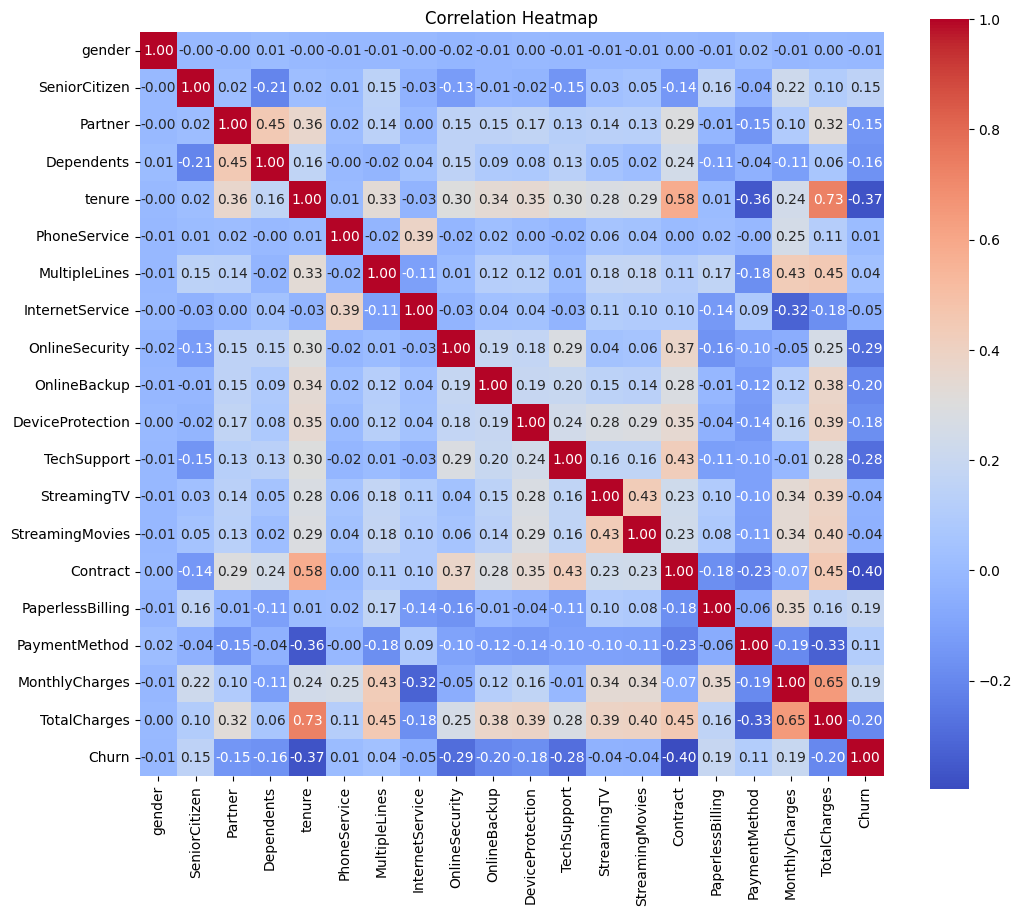

In [24]:
#heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df_copy.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [25]:
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,0.693147,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,3.555348,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,1.098612,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,3.828641,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,1.098612,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


Feature Selection

Selected features based on ANOVA F-value:
 Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')


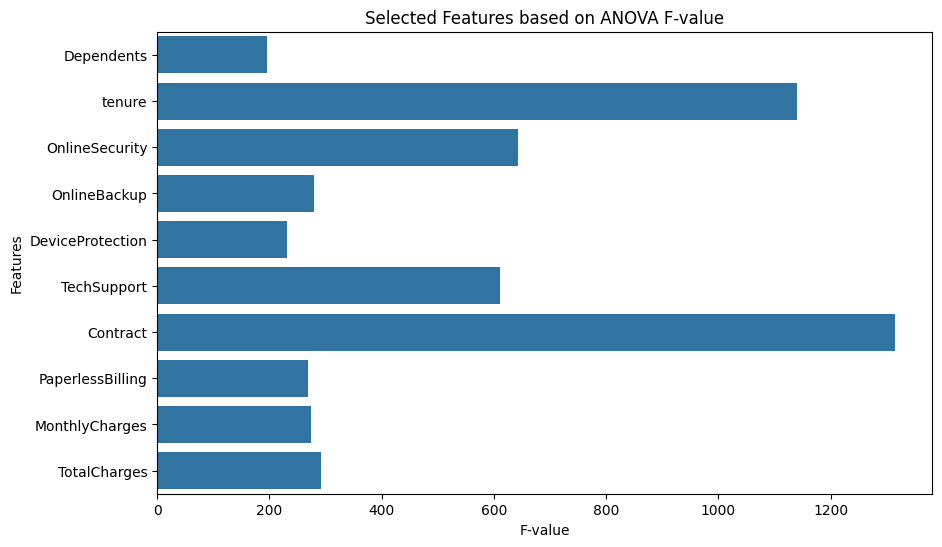

In [26]:
#feature selection
from sklearn.feature_selection import SelectKBest, f_classif
X = df_copy.drop('Churn', axis=1)
y = df_copy['Churn']
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
# Get the selected feature indices
selected_indices = selector.get_support(indices=True)
# Get the selected feature names
selected_features = X.columns[selected_indices]
print("Selected features based on ANOVA F-value:\n", selected_features)
#Visualize the selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=selector.scores_[selected_indices], y=selected_features)
plt.title('Selected Features based on ANOVA F-value')
plt.xlabel('F-value')
plt.ylabel('Features')
plt.show()

Model I ------------

In [27]:
#Keep only the selected features
X_selected = X[selected_features]
#Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=50)
#Scale the features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
#Train a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
#Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1041
           1       0.62      0.53      0.57       368

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409

Confusion Matrix:
 [[919 122]
 [172 196]]


In [28]:
print(X_selected.head())

   Dependents    tenure  OnlineSecurity  OnlineBackup  DeviceProtection  \
0           0  0.693147               0             2                 0   
1           0  3.555348               2             0                 2   
2           0  1.098612               2             2                 0   
3           0  3.828641               2             0                 2   
4           0  1.098612               0             0                 0   

   TechSupport  Contract  PaperlessBilling  MonthlyCharges  TotalCharges  
0            0         0                 1           29.85         29.85  
1            0         1                 0           56.95       1889.50  
2            0         0                 1           53.85        108.15  
3            2         1                 0           42.30       1840.75  
4            0         0                 1           70.70        151.65  


KNN Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      1041
           1       0.65      0.38      0.48       368

    accuracy                           0.79      1409
   macro avg       0.73      0.66      0.67      1409
weighted avg       0.77      0.79      0.77      1409

KNN Confusion Matrix:
 [[966  75]
 [227 141]]


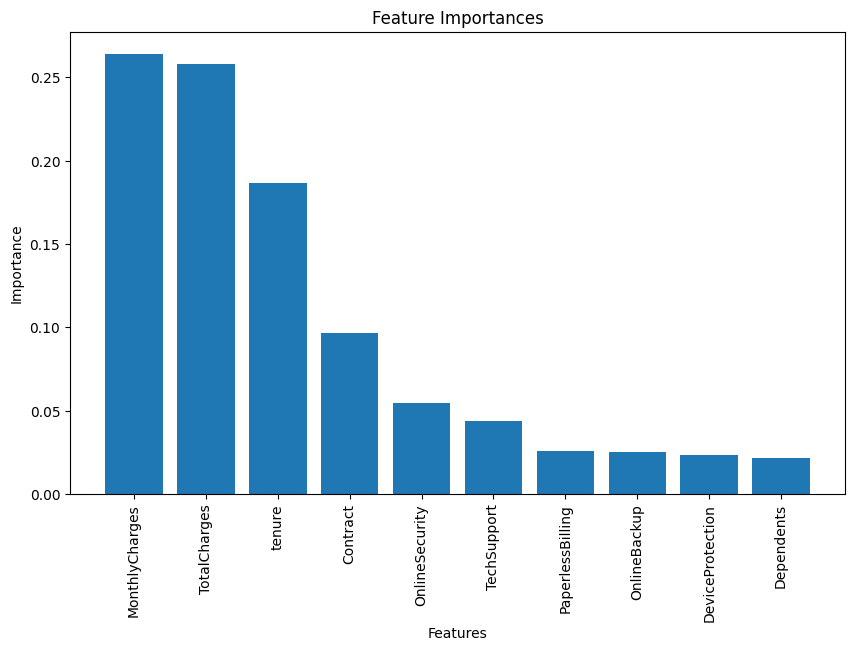

In [29]:
#kneighbors classifier
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)
#Evaluate the KNN model
y_pred_knn = knn_model.predict(X_test)
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
#Visualize feature importance
importances = rf_model.feature_importances_
feature_names = X_selected.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_selected.shape[1]), importances[indices], align='center')
plt.xticks(range(X_selected.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [30]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
#Evaluate the Decision Tree model
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1041
           1       0.49      0.50      0.50       368

    accuracy                           0.74      1409
   macro avg       0.66      0.66      0.66      1409
weighted avg       0.74      0.74      0.74      1409

Decision Tree Confusion Matrix:
 [[853 188]
 [185 183]]


In [31]:
##Support Vector Machine Classifier
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
#Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1041
           1       0.66      0.44      0.53       368

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409

SVM Confusion Matrix:
 [[956  85]
 [206 162]]


In [32]:
#Linear Regression for predicting Churn
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
#Evaluate the Logistic Regression model
y_pred_log_reg = log_reg_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1041
           1       0.65      0.54      0.59       368

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

Logistic Regression Confusion Matrix:
 [[937 104]
 [171 197]]


Pipeline